In [1]:
import sys

sys.path.append('/Users/markbills/Library/CloudStorage/OneDrive-Transformativ,LLC/Clients/Ovation Holdings/src')

In [2]:
# Azure Data Lake libraries
import azure_data_lake_interface as adl

# data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helper function libraries
from helper_functions import load_config

In [3]:
# attach to the data lake
config = load_config("config/datalake_config.json", flush_cache=True)
service_client = adl.get_azure_service_client(config["blob_url"])

container_name = "consolidated"
file_system_client = adl.get_azure_file_system_client(service_client, container_name)

In [4]:
# get data
source_folder = "enhanced/netsuite"
filename = "unit_margin_analysis.parquet"
df = adl.get_parquet_file_from_data_lake(file_system_client, source_folder, filename)

In [5]:
filtered_df = df[
    (df['gross_unit_margin_pct'] != float('-inf')) &
    (df['gross_unit_margin_pct'].notna()) &
    (df['gross_unit_margin_pct'] > 0) &
    (df['gross_unit_margin_pct'] < 100)
    ]
filtered_df = filtered_df.reset_index()

filtered_df['year'] = filtered_df['Month'].dt.year
filtered_df = filtered_df[filtered_df['year'] >= 2024]
manufacturer = filtered_df.groupby(['year', 'manufacturer']).agg({
    'gross_unit_margin_pct': 'mean',
    'total_sales': 'sum',
})

In [6]:
# Get total sales by manufacturer
manufacturer_sales = manufacturer.groupby('manufacturer')['total_sales'].sum().sort_values(ascending=False)
manufacturer_sales

manufacturer
Not Specified               4.066989e+07
Consolidated                2.474314e+07
nVent Raychem               2.275377e+07
Kunkle                      6.977343e+06
Yokogawa                    6.914617e+06
                                ...     
Digi-Key                    0.000000e+00
Draco                       0.000000e+00
Valvcon                     0.000000e+00
Valve Sales, Inc.           0.000000e+00
Armitage Machine Company    0.000000e+00
Name: total_sales, Length: 453, dtype: float64

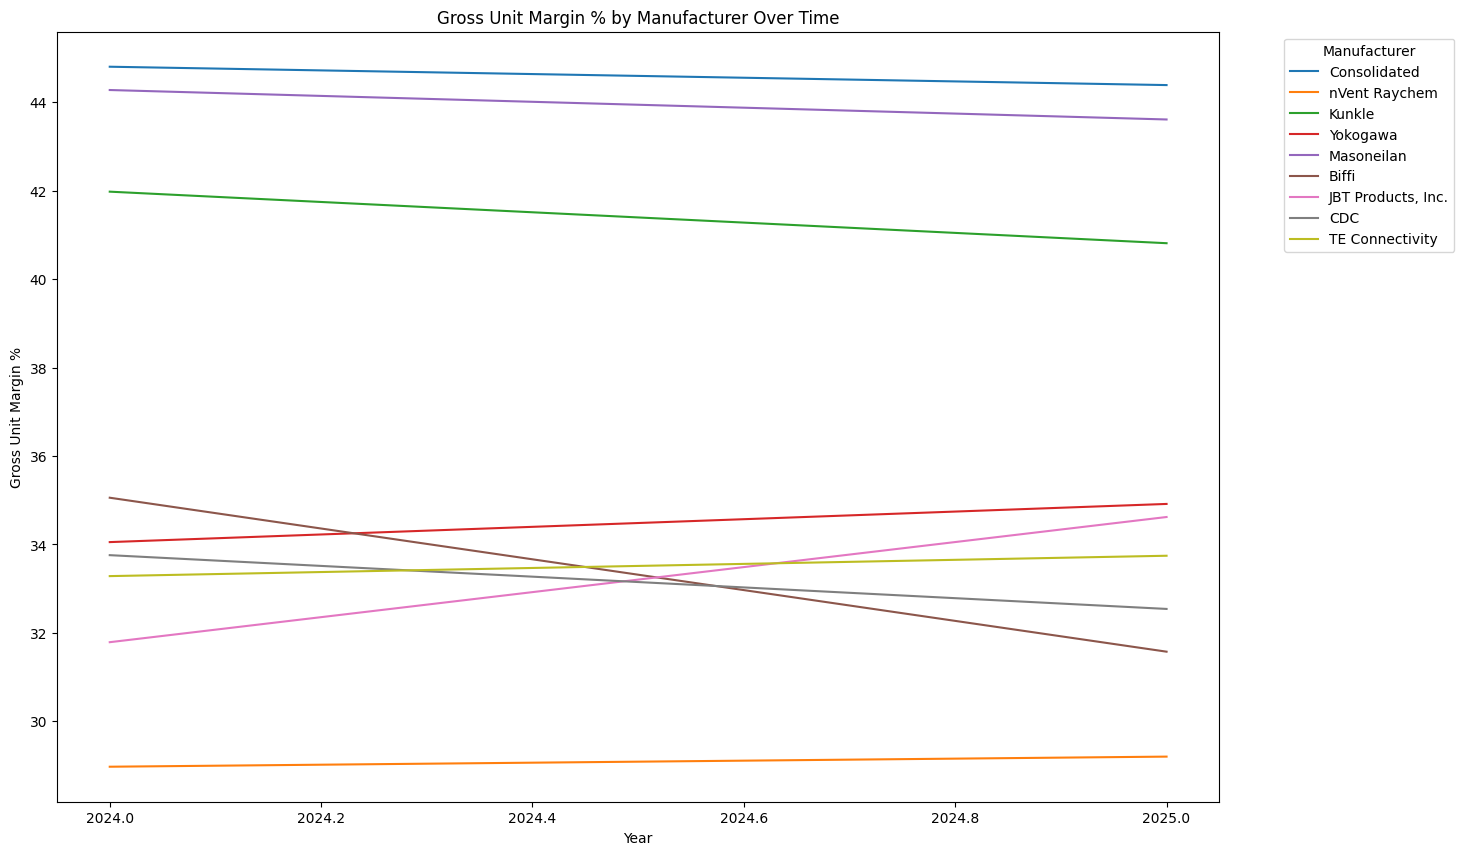

In [7]:
# Select subset of manufacturers to plot (example manufacturers)
selected_manufacturers = manufacturer_sales[1:10]

# Filter data by date range and manufacturers
manufacturer_filtered = manufacturer.loc[(slice(None), selected_manufacturers.index), 'gross_unit_margin_pct']

# Create plot
manufacturer_filtered.unstack().plot(kind='line', figsize=(15, 10),
                                     title='Gross Unit Margin % by Manufacturer Over Time')
plt.xlabel('Year')
plt.ylabel('Gross Unit Margin %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Manufacturer');